In [ ]:
## Import Library

import os
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetB3, MobileNetV2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Pre-Processing

In [2]:
# Fungsi untuk merubah gambar menjadi threshold dan mendapatkan ROI
def preprocess_image(img):
    # Konversi gambar ke skala abu-abu
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Preprocessing: Thresholding Otsu
    _, threshold = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Preprocessing: ROI (Region of Interest)
    roi = cv2.bitwise_and(img, img, mask=threshold)
    
    # Ubah ukuran ROI menjadi image_size (misalnya 224x224)
    resized_roi = cv2.resize(roi, image_size)
    
    return resized_roi

In [3]:
start_time = time.time()
# Path ke direktori dataset yang telah diekstrak
dataset_dir = "../SMIDS"
# List kelas yang ada dalam dataset
class_names = ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"]
# Ukuran Gambar
image_size = (224, 224)

# List untuk menyimpan gambar dan label
images = []
labels = []

# Loop melalui setiap kelas
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    class_label = class_names.index(class_name)
    
    # Loop melalui setiap gambar dalam kelas
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        
        # Baca gambar
        img = cv2.imread(img_path)
        
        # Simpan gambar dan label ke dalam list
        images.append(img)
        labels.append(class_label)

# Konversi list gambar dan label menjadi array numpy
images = np.array(images)
labels = np.array(labels)

# List untuk menyimpan gambar hasil preprocessing dan label
processed_images = []

# Loop melalui setiap gambar
for img in images:
    # Preprocess gambar
    resized_roi = preprocess_image(img)
    
    # Simpan gambar hasil preprocessing dan label ke dalam list
    processed_images.append(resized_roi)

# Konversi list gambar hasil preprocessing menjadi array numpy
processed_images = np.array(processed_images)

# Cetak shape dari gambar hasil preprocessing
print("Shape gambar hasil preprocessing:", processed_images.shape)
end_time = time.time()
execution_time = end_time - start_time
print(f"\nWaktu eksekusi preprocessing: {execution_time:.2f} detik\n")

<ipython-input-3-7c93468dc1d3>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


Shape gambar hasil preprocessing: (3000, 224, 224, 3)

Waktu eksekusi preprocessing: 1.21 detik



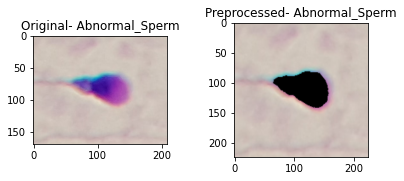

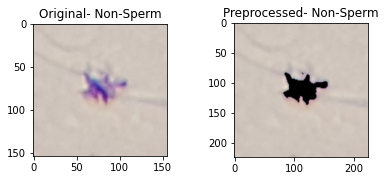

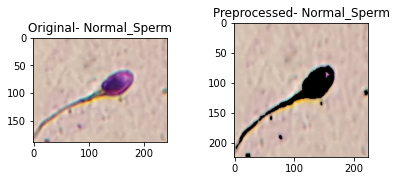


Waktu eksekusi menampilkan sample prapemrosesan: 0.83 detik



In [4]:
start_time = time.time()
# Ambil satu gambar dari setiap kelas
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    img_name = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_name)
    img = cv2.imread(img_path)
    
    # Preprocess gambar
    resized_roi = preprocess_image(img)
    
    # Tampilkan gambar asli dan gambar setelah preprocessing
    fig, axs = plt.subplots(1, 2)
    
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original- {}'.format(class_name))
    
    axs[1].imshow(cv2.cvtColor(resized_roi, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Preprocessed- {}'.format(class_name))
    
    # Atur jarak antara subplot ke samping
    fig.subplots_adjust(wspace=0.5)
    
    # Atur jarak antara subplot ke atas
    fig.subplots_adjust(hspace=0.5)
    
    plt.show()
end_time = time.time()
execution_time = end_time - start_time
print(f"\nWaktu eksekusi menampilkan sample prapemrosesan: {execution_time:.2f} detik\n")

## Pemisahan Data

In [5]:
start_time = time.time()
# Pembagian dataset menjadi subset pelatihan, validasi, dan pengujian
train_images, testval_images, train_labels, testval_labels = train_test_split(processed_images, labels, train_size=0.60, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(testval_images, testval_labels, test_size=0.50, random_state=42)

# Cetak jumlah data pada masing-masing subset
print("Jumlah data pelatihan:", len(train_images))
print("Jumlah data validasi:", len(val_images))
print("Jumlah data pengujian:", len(test_images))
end_time = time.time()
execution_time = end_time - start_time
print(f"\nWaktu eksekusi pemisahan data: {execution_time:.2f} detik\n")

Jumlah data pelatihan: 1800
Jumlah data validasi: 600
Jumlah data pengujian: 600

Waktu eksekusi pemisahan data: 0.14 detik



In [6]:
# Define the augmentation parameters
data_augmentation = ImageDataGenerator(
    brightness_range=[0.2, 0.8],  # Adjust brightness randomly between 0.2 and 0.8
    rotation_range=360,           # Randomly rotate images by up to 360 degrees
    horizontal_flip=True,         # Randomly flip images horizontally
    vertical_flip=True            # Randomly flip images vertically
)

In [7]:
# Membuat ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)

# Menggunakan pre-trained model EfficientNetB0 tanpa fully connected layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Menambahkan fully connected layer dan output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Menggabungkan model base dan layer tambahan
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan layer base agar tidak terupdate saat melatih layer tambahan
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model dengan optimizer SGD
model.compile(optimizer=SGD(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [8]:
# Pelatihan model
start_time = time.time()
history_tl = model.fit(data_augmentation.flow(train_images, train_labels, batch_size=32), epochs=25, batch_size=32, 
                       validation_data=(val_images, val_labels), callbacks=[reduce_lr])
end_time = time.time()
execution_time = end_time - start_time
print(f"\nWaktu eksekusi melatih model transfer learning: {execution_time:.2f} detik\n")

Epoch 1/25
57/57 [==============================] - 112s 1s/step - loss: 1.0732 - accuracy: 0.4196 - val_loss: 1.0419 - val_accuracy: 0.4583
Epoch 2/25
57/57 [==============================] - 21s 367ms/step - loss: 1.0070 - accuracy: 0.5182 - val_loss: 0.9846 - val_accuracy: 0.5400
Epoch 3/25
57/57 [==============================] - 21s 364ms/step - loss: 0.9445 - accuracy: 0.5927 - val_loss: 0.9422 - val_accuracy: 0.5850
Epoch 4/25
57/57 [==============================] - 21s 362ms/step - loss: 0.9029 - accuracy: 0.6359 - val_loss: 0.9098 - val_accuracy: 0.6100
Epoch 5/25
57/57 [==============================] - 21s 370ms/step - loss: 0.8702 - accuracy: 0.6600 - val_loss: 0.8825 - val_accuracy: 0.6200
Epoch 6/25
57/57 [==============================] - 21s 363ms/step - loss: 0.8469 - accuracy: 0.6578 - val_loss: 0.8579 - val_accuracy: 0.6417
Epoch 7/25
57/57 [==============================] - 21s 366ms/step - loss: 0.8172 - accuracy: 0.6764 - val_loss: 0.8371 - val_accuracy: 0.6433
E

In [9]:
# Evaluate the Tranfer Learning model on the training data
train_loss, train_accuracy = model.evaluate(train_images, train_labels)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")
# Test the Tranfer Learning model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

57/57 [==============================] - 12s 205ms/step - loss: 0.6624 - accuracy: 0.7311
Training Loss: 0.6624
Training Accuracy: 0.7311
19/19 [==============================] - 4s 204ms/step - loss: 0.6413 - accuracy: 0.7467
Test Loss: 0.6413
Test Accuracy: 0.7467


In [10]:
# Predict labels for the train data
predictions = model.predict(train_images)
predicted_labels = np.argmax(predictions, axis=1)
# Calculate precision, recall, and specificity
print(classification_report(train_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

Abnormal_Sperm       0.68      0.66      0.67       587
     Non-Sperm       0.82      0.83      0.82       590
  Normal_Sperm       0.69      0.71      0.70       623

      accuracy                           0.73      1800
     macro avg       0.73      0.73      0.73      1800
  weighted avg       0.73      0.73      0.73      1800



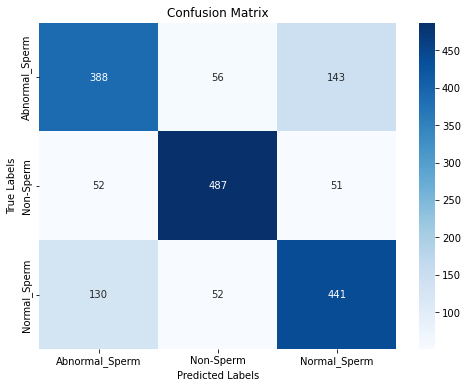

In [11]:
cm = confusion_matrix(train_labels, predicted_labels)
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [12]:
# Predict labels for the test data
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# Calculate precision, recall, and specificity
print(classification_report(test_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

Abnormal_Sperm       0.68      0.65      0.67       193
     Non-Sperm       0.85      0.86      0.85       207
  Normal_Sperm       0.70      0.72      0.71       200

      accuracy                           0.75       600
     macro avg       0.74      0.74      0.74       600
  weighted avg       0.75      0.75      0.75       600



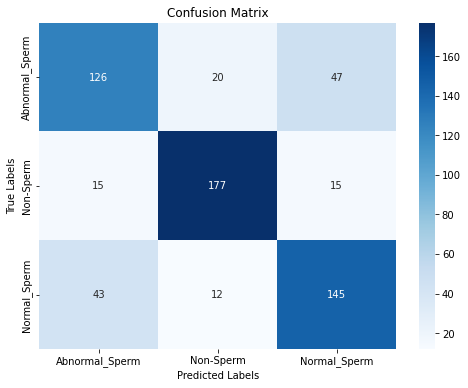

In [13]:
cm = confusion_matrix(test_labels, predicted_labels)
# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [14]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(test_labels, predicted_labels, average=None)
print("Precision:", precision)

# Calculate recall
recall = recall_score(test_labels, predicted_labels, average=None)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels, average=None)
print("F1-score:", f1)

Accuracy: 0.7466666666666667
Precision: [0.68478261 0.84688995 0.70048309]
Recall: [0.65284974 0.85507246 0.725     ]
F1-score: [0.66843501 0.85096154 0.71253071]


In [15]:
# Calculate average accuracy
average_accuracy = np.mean(accuracy)
print(f"Average Accuracy: {average_accuracy:.4f}")

# Calculate average precision
average_precision = np.mean(precision)
print(f"Average Precision: {average_precision:.4f}")

# Calculate average recall
average_recall = np.mean(recall)
print(f"Average Recall: {average_recall:.4f}")

# Calculate average F1-score
average_f1 = np.mean(f1)
print(f"Average F1-score: {average_f1:.4f}")


Average Accuracy: 0.7467
Average Precision: 0.7441
Average Recall: 0.7443
Average F1-score: 0.7440


In [16]:
# Membuka kembali layer terakhir untuk dilatih
for layer in model.layers[-7:]:
    layer.trainable = True

# Hyperparameter tuning
learning_rate = 0.0001
momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [17]:
start_time = time.time()
# Pelatihan model dengan penambahan tuning dan ReduceLROnPlateau callback
history_ft = model.fit(data_augmentation.flow(train_images, train_labels, batch_size=32), epochs=50, batch_size=32, 
                                validation_data=(val_images, val_labels), callbacks=[reduce_lr])
end_time = time.time()
execution_time = end_time - start_time
print(f"\nWaktu eksekusi melatih model Fine Tuning: {execution_time:.2f} detik\n")

Epoch 1/50
57/57 [==============================] - 31s 410ms/step - loss: 0.7307 - accuracy: 0.7052 - val_loss: 0.6794 - val_accuracy: 0.7433
Epoch 2/50
57/57 [==============================] - 21s 374ms/step - loss: 0.7096 - accuracy: 0.7202 - val_loss: 0.6845 - val_accuracy: 0.7383
Epoch 3/50
57/57 [==============================] - 21s 371ms/step - loss: 0.6777 - accuracy: 0.7371 - val_loss: 0.6778 - val_accuracy: 0.7400
Epoch 4/50
57/57 [==============================] - 21s 366ms/step - loss: 0.6559 - accuracy: 0.7383 - val_loss: 0.6663 - val_accuracy: 0.7367
Epoch 5/50
57/57 [==============================] - 21s 368ms/step - loss: 0.6509 - accuracy: 0.7454 - val_loss: 0.6561 - val_accuracy: 0.7433
Epoch 6/50
57/57 [==============================] - 21s 362ms/step - loss: 0.6330 - accuracy: 0.7388 - val_loss: 0.6451 - val_accuracy: 0.7417
Epoch 7/50
57/57 [==============================] - 21s 363ms/step - loss: 0.6328 - accuracy: 0.7520 - val_loss: 0.6357 - val_accuracy: 0.7467

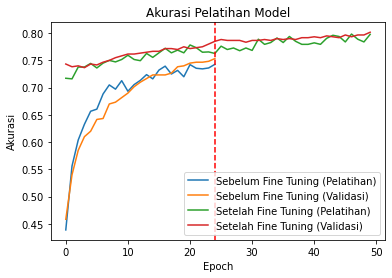

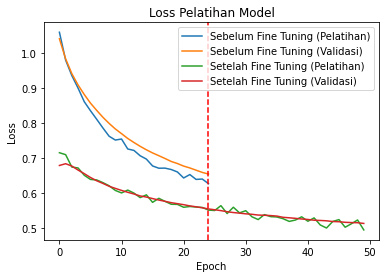

In [18]:
# Plot akurasi pelatihan
plt.plot(history_tl.history['accuracy'])
plt.plot(history_tl.history['val_accuracy'])
plt.plot(history_ft.history['accuracy'])
plt.plot(history_ft.history['val_accuracy'])
plt.axvline(x=25-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Akurasi Pelatihan Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(['Sebelum Fine Tuning (Pelatihan)', 'Sebelum Fine Tuning (Validasi)', 
            'Setelah Fine Tuning (Pelatihan)', 'Setelah Fine Tuning (Validasi)'])
plt.show()

# Plot loss pelatihan
plt.plot(history_tl.history['loss'])
plt.plot(history_tl.history['val_loss'])
plt.plot(history_ft.history['loss'])
plt.plot(history_ft.history['val_loss'])
plt.axvline(x=25-1, color='r', linestyle='--', label='Start Fine-Tuning')
plt.title('Loss Pelatihan Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Sebelum Fine Tuning (Pelatihan)', 'Sebelum Fine Tuning (Validasi)', 
            'Setelah Fine Tuning (Pelatihan)', 'Setelah Fine Tuning (Validasi)'])
plt.show()


In [19]:
# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(train_images, train_labels)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Test the final model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

57/57 [==============================] - 12s 205ms/step - loss: 0.5091 - accuracy: 0.7917
Training Loss: 0.5091
Training Accuracy: 0.7917
19/19 [==============================] - 4s 205ms/step - loss: 0.5204 - accuracy: 0.7950
Test Loss: 0.5204
Test Accuracy: 0.7950


In [20]:
# Predict labels for the train data
predictions = model.predict(train_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, and specificity
print(classification_report(train_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

Abnormal_Sperm       0.72      0.78      0.75       587
     Non-Sperm       0.87      0.86      0.86       590
  Normal_Sperm       0.80      0.74      0.77       623

      accuracy                           0.79      1800
     macro avg       0.79      0.79      0.79      1800
  weighted avg       0.79      0.79      0.79      1800



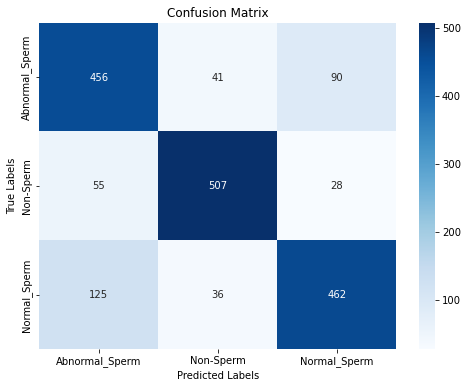

In [21]:
cm = confusion_matrix(train_labels, predicted_labels)
class_names = ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [22]:
# Predict labels for the test data
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate precision, recall, and specificity
print(classification_report(test_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

Abnormal_Sperm       0.72      0.76      0.74       193
     Non-Sperm       0.87      0.86      0.87       207
  Normal_Sperm       0.80      0.77      0.78       200

      accuracy                           0.80       600
     macro avg       0.80      0.79      0.79       600
  weighted avg       0.80      0.80      0.80       600



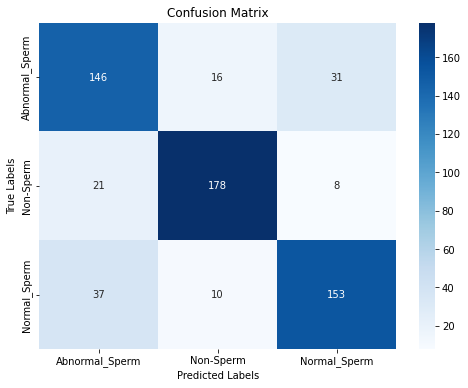

In [23]:
cm = confusion_matrix(test_labels, predicted_labels)
class_names = ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"]

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [24]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(test_labels, predicted_labels, average=None)
print("Precision:", precision)

# Calculate recall
recall = recall_score(test_labels, predicted_labels, average=None)
print("Recall:", recall)

# Calculate F1-score
f1 = f1_score(test_labels, predicted_labels, average=None)
print("F1-score:", f1)

Accuracy: 0.795
Precision: [0.71568627 0.87254902 0.796875  ]
Recall: [0.75647668 0.85990338 0.765     ]
F1-score: [0.73551637 0.86618005 0.78061224]


In [25]:
# Calculate average accuracy
average_accuracy = np.mean(accuracy)
print(f"Average Accuracy: {average_accuracy:.4f}")

# Calculate average precision
average_precision = np.mean(precision)
print(f"Average Precision: {average_precision:.4f}")

# Calculate average recall
average_recall = np.mean(recall)
print(f"Average Recall: {average_recall:.4f}")

# Calculate average F1-score
average_f1 = np.mean(f1)
print(f"Average F1-score: {average_f1:.4f}")


Average Accuracy: 0.7950
Average Precision: 0.7950
Average Recall: 0.7938
Average F1-score: 0.7941


In [26]:
# Create a DataFrame for misclassifications
misclassified_df = pd.DataFrame({'Actual Label': test_labels, 'Predicted Label': predicted_labels})

# Map class_names to their respective labels
class_labels = {class_names.index(class_name): class_name for class_name in class_names}
misclassified_df['Actual Class'] = misclassified_df['Actual Label'].map(class_labels)
misclassified_df['Predicted Class'] = misclassified_df['Predicted Label'].map(class_labels)

# Add a column for correct/incorrect classification
misclassified_df['Correct'] = misclassified_df['Actual Label'] == misclassified_df['Predicted Label']

# Filter misclassified samples
misclassified_samples = misclassified_df[misclassified_df['Correct'] == False]

# Add True Classification column
true_classification = [class_names[label] for label in misclassified_samples['Actual Label']]
misclassified_samples['True Classification'] = true_classification

# Export misclassified samples to CSV
misclassified_samples.to_csv('misclassified_samples.csv', index=False)


<ipython-input-26-a0bc06f8b2b4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_samples['True Classification'] = true_classification


In [27]:
# Perform inference on the test data
predictions = model.predict(test_images)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_class_names = [class_names[label] for label in predicted_labels]

# Convert the true labels to class names
true_class_names = [class_names[label] for label in test_labels]

# Display the true and predicted labels
for true_label, predicted_label in zip(true_class_names, predicted_class_names):
    if true_label == predicted_label:
        print(f"True Label: {true_label} - Predicted Label: {predicted_label} - Correct")
    else:
        print(f"True Label: {true_label} - Predicted Label: {predicted_label} - Incorrect")


True Label: Abnormal_Sperm - Predicted Label: Abnormal_Sperm - Correct
True Label: Normal_Sperm - Predicted Label: Non-Sperm - Incorrect
True Label: Abnormal_Sperm - Predicted Label: Abnormal_Sperm - Correct
True Label: Abnormal_Sperm - Predicted Label: Abnormal_Sperm - Correct
True Label: Normal_Sperm - Predicted Label: Normal_Sperm - Correct
True Label: Non-Sperm - Predicted Label: Non-Sperm - Correct
True Label: Normal_Sperm - Predicted Label: Abnormal_Sperm - Incorrect
True Label: Normal_Sperm - Predicted Label: Normal_Sperm - Correct
True Label: Abnormal_Sperm - Predicted Label: Abnormal_Sperm - Correct
True Label: Abnormal_Sperm - Predicted Label: Abnormal_Sperm - Correct
True Label: Normal_Sperm - Predicted Label: Normal_Sperm - Correct
True Label: Non-Sperm - Predicted Label: Non-Sperm - Correct
True Label: Non-Sperm - Predicted Label: Non-Sperm - Correct
True Label: Non-Sperm - Predicted Label: Abnormal_Sperm - Incorrect
True Label: Normal_Sperm - Predicted Label: Normal_Sperm

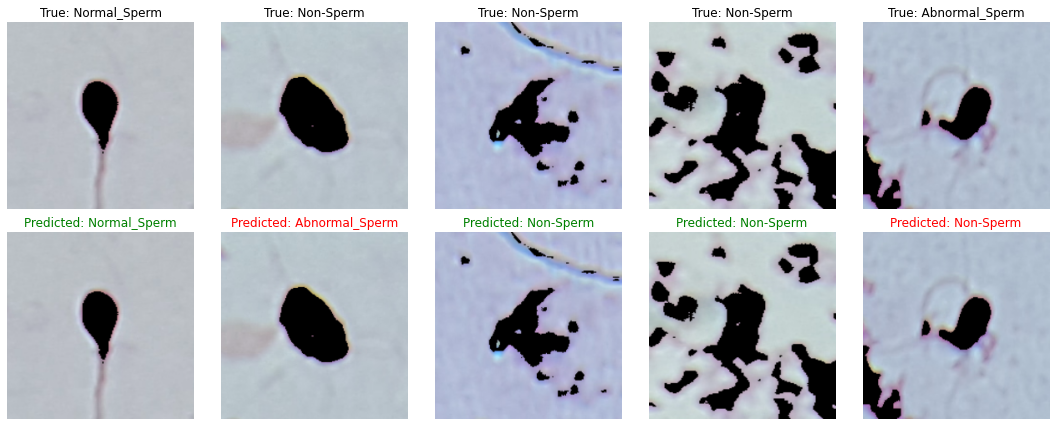

In [28]:
# Define the number of images to visualize
num_images = 5

# Select random indices from the test data
indices = np.random.choice(len(test_images), size=num_images, replace=False)

# Create subplots for displaying the images
fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(15, 6))

# Iterate over the selected indices
for i, idx in enumerate(indices):
    # Get the image, true label, and predicted label
    image = test_images[idx]
    true_label = true_class_names[idx]
    predicted_label = predicted_class_names[idx]

    # Display the image
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"True: {true_label}")
    
    # Set the color of the title based on the correctness of the prediction
    title_color = 'green' if true_label == predicted_label else 'red'
    axes[1, i].imshow(image)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Predicted: {predicted_label}", color=title_color)

plt.tight_layout()
plt.show()
